In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
               datasets.MNIST(root='.', train=True, download=True,
               transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ])), batch_size=64, shuffle=True, num_workers=0)

# Test dataset
test_loader = torch.utils.data.DataLoader(
              datasets.MNIST(root='.', train=False, 
              transform=transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,))
              ])), batch_size=64, shuffle=True, num_workers=0)

#### Spatial transformer networks boils down to three main components:
1. The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead network learns automatically the spatial transformations that enhances the global accuracy. 

2. The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.

3. The sampler uses the parameters of the transformation and applies it to the input image.

In [3]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8,10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3*2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        #Initialize the weihts/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0],
                                                    dtype=torch.float))
        
    def stn(self, x):
    
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        
        x = F.grid_sample(x, grid)
        
        return x
        
    def forward(self, x):
        # transform the input
        x = self.stn(x)
        
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net().to(device)

# Training the model

In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
    
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

# Visualize the STN results

In [5]:
def convert_image_np(inp):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

def visualize_stn():
    
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)
        
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        
        in_grid = convert_image_np(
                torchvision.utils.make_grid(input_tensor))
        
        out_grid = convert_image_np(
                torchvision.utils.make_grid(transformed_input_tensor))
        
        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        

In [6]:
for epoch in range(1, 21):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.377180
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.037173


/home/notebook/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3025, Accuracy: 9126/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.782390
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.443878

Test set: Average loss: 0.1351, Accuracy: 9592/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.530306
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.124398

Test set: Average loss: 0.0942, Accuracy: 9707/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.145014
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.190130

Test set: Average loss: 4.5654, Accuracy: 1241/10000 (12%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 5.153703
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.128704

Test set: Average loss: 0.0662, Accuracy: 9791/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.071413
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.083731

Test set: Average loss: 0.0694, Accuracy: 9768/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.122484
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.062900

Test set: Average loss: 0.0684, Accuracy: 9782/10000 (98%)

Tra

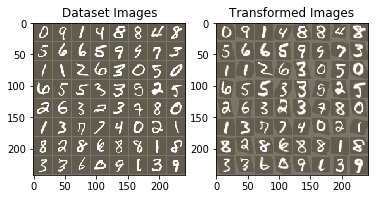

In [7]:
# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()